# Block 1:Install libraries

In [ ]:
!pip install -U datasets
!pip install -U spacy
!pip install -U torchmetrics
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 122.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 86.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


#Block 2:Imports & Setup

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import random
import numpy as np
import spacy
import matplotlib.pyplot as plt
from datasets import load_dataset, concatenate_datasets
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torchmetrics.text import BLEUScore
from tqdm import tqdm

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device being used: {device}")

Device being used: cuda


#Block 3: Data Loading

In [ ]:
print("Loading dataset...")
dataset = load_dataset("bentrevett/multi30k")

print("Splitting data into 80% Training and 20% Testing...")
split_data = dataset['train'].train_test_split(test_size=0.2, seed=SEED)

train_data = split_data['train']
test_data = split_data['test']

print(f"Final Training Set Size (80%): {len(train_data)}")
print(f"Final Testing Set Size (20%): {len(test_data)}")

Loading dataset...
Splitting data into 80% Training and 20% Testing...
Final Training Set Size (80%): 23200
Final Testing Set Size (20%): 5800


#Block 4: Preprocessing

In [ ]:
# Load Spacy models
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

def build_vocab(data, tokenizer, min_freq=2):
    vocab = {'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3}
    freqs = {}
    for item in data:
        tokens = tokenizer(item)
        for token in tokens:
            freqs[token] = freqs.get(token, 0) + 1
    for token, freq in freqs.items():
        if freq >= min_freq:
            vocab[token] = len(vocab)
    return vocab

print("Building Vocabularies...")
train_src = [x['en'] for x in train_data]
train_trg = [x['de'] for x in train_data]

src_vocab = build_vocab(train_src, tokenize_en)
trg_vocab = build_vocab(train_trg, tokenize_de)

print(f"Source (EN) Vocab Size: {len(src_vocab)}")
print(f"Target (DE) Vocab Size: {len(trg_vocab)}")

class TranslationDataset(Dataset):
    def __init__(self, data, src_vocab, trg_vocab, src_tokenizer, trg_tokenizer):
        self.data = data
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer

    def __len__(self):
        return len(self.data)

    def text_to_indices(self, text, vocab, tokenizer):
        tokens = tokenizer(text)
        indices = [vocab.get(token, vocab['<unk>']) for token in tokens]
        return [2] + indices + [3]

    def __getitem__(self, idx):
        item = self.data[idx]
        src_tensor = torch.tensor(self.text_to_indices(item['en'], self.src_vocab, self.src_tokenizer))
        trg_tensor = torch.tensor(self.text_to_indices(item['de'], self.trg_vocab, self.trg_tokenizer))
        return src_tensor, trg_tensor

def collate_fn(batch):
    src_batch, trg_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, padding_value=1, batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=1, batch_first=True)
    return src_batch, trg_batch

BATCH_SIZE = 64
train_loader = DataLoader(TranslationDataset(train_data, src_vocab, trg_vocab, tokenize_en, tokenize_de),
                          batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(TranslationDataset(test_data, src_vocab, trg_vocab, tokenize_en, tokenize_de),
                         batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

Building Vocabularies...
Source (EN) Vocab Size: 5558
Target (DE) Vocab Size: 6952


# Block 5:Transformer Model

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, d_model, nhead,
                 num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, max_len=100):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.trg_embedding = nn.Embedding(trg_vocab_size, d_model)
        self.pos_encoder = nn.Embedding(max_len, d_model)
        self.pos_decoder = nn.Embedding(max_len, d_model)

        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, batch_first=True)
        self.fc_out = nn.Linear(d_model, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = 1
        self.trg_pad_idx = 1

    def forward(self, src, trg):
        src_seq_len, trg_seq_len = src.shape[1], trg.shape[1]
        src_positions = (torch.arange(0, src_seq_len).unsqueeze(0).repeat(src.shape[0], 1)).to(device)
        trg_positions = (torch.arange(0, trg_seq_len).unsqueeze(0).repeat(trg.shape[0], 1)).to(device)

        embed_src = self.dropout((self.src_embedding(src) + self.pos_encoder(src_positions)) * math.sqrt(self.d_model))
        embed_trg = self.dropout((self.trg_embedding(trg) + self.pos_decoder(trg_positions)) * math.sqrt(self.d_model))

        src_padding_mask = (src == self.src_pad_idx)
        tgt_padding_mask = (trg == self.trg_pad_idx)
        tgt_mask = self.transformer.generate_square_subsequent_mask(trg_seq_len).to(device)

        return self.fc_out(self.transformer(embed_src, embed_trg, src_key_padding_mask=src_padding_mask, tgt_key_padding_mask=tgt_padding_mask, tgt_mask=tgt_mask))

# Block 6: Training Logic

In [ ]:
INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
D_MODEL = 256
N_HEAD = 8
N_ENCODER_LAYERS = 3
N_DECODER_LAYERS = 3
DIM_FEEDFORWARD = 512
DROPOUT = 0.1
LEARNING_RATE = 0.0005
N_EPOCHS = 10

model = TransformerModel(INPUT_DIM, OUTPUT_DIM, D_MODEL, N_HEAD,
                         N_ENCODER_LAYERS, N_DECODER_LAYERS,
                         DIM_FEEDFORWARD, DROPOUT).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=1)

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for src, trg in tqdm(loader, desc="Training"):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg[:, :-1])
        output = output.reshape(-1, output.shape[-1])
        loss = criterion(output, trg[:, 1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def evaluate_epoch(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, trg in loader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg[:, :-1])
            output = output.reshape(-1, output.shape[-1])
            loss = criterion(output, trg[:, 1:].reshape(-1))
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

def translate_sentence(model, sentence_tensor, max_len=50):
    model.eval()
    sentence_tensor = sentence_tensor.unsqueeze(0).to(device)
    trg_indices = [2]
    for i in range(max_len):
        trg_tensor = torch.tensor(trg_indices).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(sentence_tensor, trg_tensor)
        pred_token = output.argmax(2)[:, -1].item()
        trg_indices.append(pred_token)
        if pred_token == 3: break
    return trg_indices[1:-1]

# Block 7: Execution & Results

Starting Training for 10 Epochs...


Training: 100%|██████████| 363/363 [00:17<00:00, 20.54it/s]


Epoch: 01 | Train Loss: 4.373 | Val. Loss: 3.546 | Val. PPL: 34.657


Training: 100%|██████████| 363/363 [00:17<00:00, 20.32it/s]


Epoch: 02 | Train Loss: 3.315 | Val. Loss: 2.969 | Val. PPL: 19.476


Training: 100%|██████████| 363/363 [00:17<00:00, 20.45it/s]


Epoch: 03 | Train Loss: 2.819 | Val. Loss: 2.626 | Val. PPL: 13.814


Training: 100%|██████████| 363/363 [00:17<00:00, 20.86it/s]


Epoch: 04 | Train Loss: 2.470 | Val. Loss: 2.370 | Val. PPL: 10.695


Training: 100%|██████████| 363/363 [00:17<00:00, 20.35it/s]


Epoch: 05 | Train Loss: 2.181 | Val. Loss: 2.230 | Val. PPL: 9.299


Training: 100%|██████████| 363/363 [00:20<00:00, 17.55it/s]


Epoch: 06 | Train Loss: 1.947 | Val. Loss: 2.043 | Val. PPL: 7.713


Training: 100%|██████████| 363/363 [00:17<00:00, 20.41it/s]


Epoch: 07 | Train Loss: 1.757 | Val. Loss: 1.937 | Val. PPL: 6.940


Training: 100%|██████████| 363/363 [00:17<00:00, 20.24it/s]


Epoch: 08 | Train Loss: 1.607 | Val. Loss: 1.886 | Val. PPL: 6.595


Training: 100%|██████████| 363/363 [00:18<00:00, 19.23it/s]


Epoch: 09 | Train Loss: 1.471 | Val. Loss: 1.816 | Val. PPL: 6.150


Training: 100%|██████████| 363/363 [00:17<00:00, 20.45it/s]


Epoch: 10 | Train Loss: 1.356 | Val. Loss: 1.799 | Val. PPL: 6.045


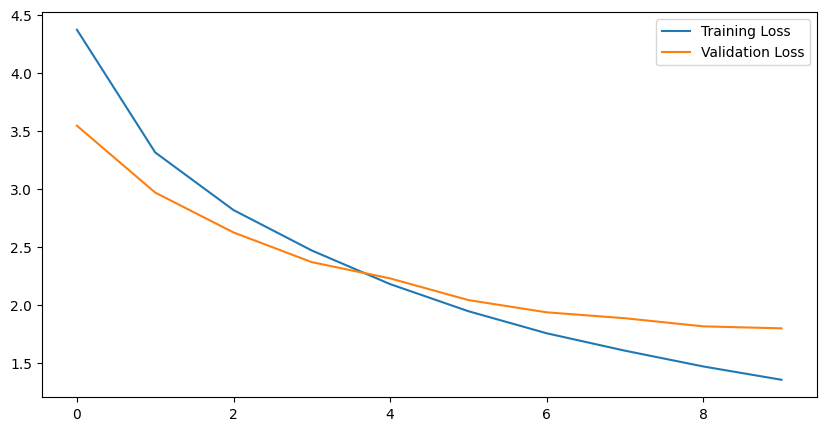

Calculating BLEU Score...


Translating: 100%|██████████| 5800/5800 [10:04<00:00,  9.60it/s]


Final BLEU Score: 27.20


In [ ]:
train_losses = []
valid_losses = []

print(f"Starting Training for {N_EPOCHS} Epochs...")

for epoch in range(N_EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    valid_loss = evaluate_epoch(model, test_loader, criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):.3f}')

plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.show()

print("Calculating BLEU Score...")
preds = []
targets = []
inv_trg_vocab = {v: k for k, v in trg_vocab.items()}

model.eval()
for i in tqdm(range(len(test_loader.dataset)), desc="Translating"):
    src_tensor, trg_tensor = test_loader.dataset[i]
    pred_indices = translate_sentence(model, src_tensor)
    preds.append(" ".join([inv_trg_vocab.get(idx, '<unk>') for idx in pred_indices]))
    trg_indices = trg_tensor.tolist()
    targets.append([" ".join([inv_trg_vocab.get(idx, '<unk>') for idx in trg_indices if idx not in [1, 2, 3]])])

bleu = BLEUScore()
print(f"Final BLEU Score: {bleu(preds, targets).item()*100:.2f}")

# Block 8 Sample Translation

In [ ]:
print("\n--- SAMPLE TRANSLATIONS ---\n")

inv_trg_vocab = {v: k for k, v in trg_vocab.items()}

model.eval()

for i in range(5):
    raw_src = test_data[i]['en']
    raw_trg = test_data[i]['de']

    src_tensor, _ = test_loader.dataset[i]

    pred_indices = translate_sentence(model, src_tensor)

    pred_tokens = [inv_trg_vocab.get(idx, '<unk>') for idx in pred_indices]
    pred_string = " ".join(pred_tokens)

    print(f"Example {i+1}:")
    print(f"EN  : {raw_src}")
    print(f"REF : {raw_trg}")
    print(f"PRED: {pred_string}")
    print("-" * 40)


--- SAMPLE TRANSLATIONS ---

Example 1:
EN  : There are several Asian children sitting cross legged on a concrete floor.
REF : Mehrere asiatische Kinde sitzen mit überkreuzten Beinen auf einem Betonboden.
PRED: Zwei asiatische Kinder sitzen auf einem Beton und sitzen auf einem Beton .
----------------------------------------
Example 2:
EN  : A young woman is stroking the white rabbit that is sitting on her leg.
REF : Eine junge Frau streichelt das weiße Kaninchen, das auf ihrem Bein sitzt.
PRED: Eine junge Frau sitzt auf dem Bein und sitzt auf ihrem Bein .
----------------------------------------
Example 3:
EN  : The employees of a culinary establishment prepare food for watching customers.
REF : Die Mitarbeiter eines Gastronomiebetriebs bereiten Essen für zuschauende Kunden zu.
PRED: Die <unk> eines <unk> bereiten Essen für Essen zu .
----------------------------------------
Example 4:
EN  : A girl in a blue dress standing next to a wooden post on sidewalk.
REF : Ein Mädchen in blaue